In [1]:
import mitsuba as mi
mi.set_variant('scalar_rgb')
tent_rfilter = mi.load_dict({'type' : 'tent'})
mi.set_variant("cuda_ad_rgb")
import drjit as dr
from enum import Enum

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

In [2]:
class Scene(Enum):
    COND1 = 1
    COND2 = 2

# Utils

In [3]:
def plot_res(images_bm, textures_bm, titles, size_factor=3):
    fig, ax = plt.subplots(ncols=2, nrows=len(images_bm), figsize=(8, size_factor*len(images_bm)), squeeze=False)
    for i, (img, tex, title) in enumerate(zip(images_bm, textures_bm, titles)):
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(tex)
        ax[i, 0].set_ylabel(title, size=14)
        ax[i, 0].set_xticks([]); ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([]); ax[i, 1].set_yticks([])
    ax[0, 0].set_title("Rendering", weight='bold', size=14)
    ax[0, 1].set_title("Roughness texture", weight='bold', size=14)
    plt.tight_layout()
    plt.show()

def plot_res2(res_dict, size_factor=3):
    titles = list(res_dict.keys())
    images_bm = [res_dict[title][0] for title in titles]
    textures_bm = [res_dict[title][1] for title in titles]
    plot_res(images_bm, textures_bm, titles, size_factor)

In [4]:
def image_to_bm(image):
    return mi.util.convert_to_bitmap(image)

def params_to_bm(params):
    return mi.util.convert_to_bitmap(params).convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, False)

In [5]:
def reset_scene(scene: Scene):
    return mi.load_file(f"../scenes/roughness_optimization_{scene.value}.xml")

# Reference scenes rendering

In [6]:
OPT_KEY = 'plane.bsdf.alpha.data'

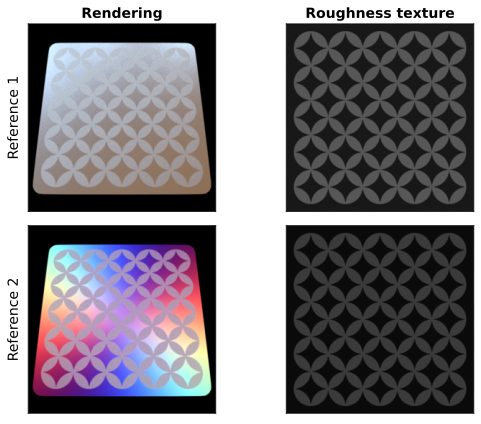

In [7]:
scene_ref = {k: reset_scene(k) for k in Scene}
params = {k: mi.traverse(scene_ref[k]) for k in Scene}

# Render reference images
image_ref = {k: mi.render(scene_ref[k], seed=0, spp=128) for k in Scene}
params_ref = {k: params[k][OPT_KEY] for k in Scene}

image_ref_bm = {k: image_to_bm(image_ref[k])  for k in Scene}
params_ref_bm = {k: params_to_bm(params_ref[k])  for k in Scene}

# Plot
plot_res2({f'Reference {k.value}': (image_ref_bm[k], params_ref_bm[k]) for k in Scene})

# Loss landscape utils

In [8]:
def rel_l1_loss(img, img_ref):
    # Relative L1 loss
    return dr.sum(dr.abs(img - img_ref) / (dr.maximum(dr.abs(img_ref), 0.001))) / len(img)

def mse(img, img_ref):
    return dr.mean(dr.sqr(img - img_ref))

In [9]:
def plot_loss_linear_interp_1D(scene_name: Scene, params_1, params_2, loss_fn=rel_l1_loss, n_samples = 100, title=None):
    alphas = np.linspace(0, 1, n_samples)
    losses = []
    for alpha in alphas:
        scene = reset_scene(scene_name)
        params = mi.traverse(scene)
        params[OPT_KEY] = (1 - alpha) * params_1 + alpha * params_2
        params.update()
        image = mi.render(scene, params, seed=0, spp=8)
        losses.append(loss_fn(image, image_ref[scene_name]))
    if title is not None:
        plt.title(title)
    plt.plot(alphas, losses)

# Experiments

## Scene 1

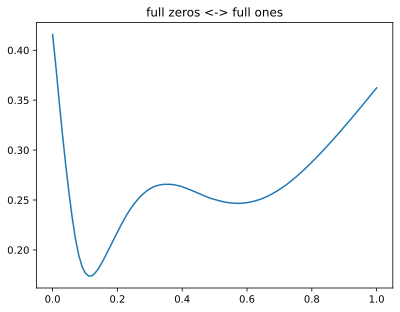

In [10]:
params_1 = mi.TensorXf(np.zeros((512, 512, 1)))
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="full zeros <-> full ones")

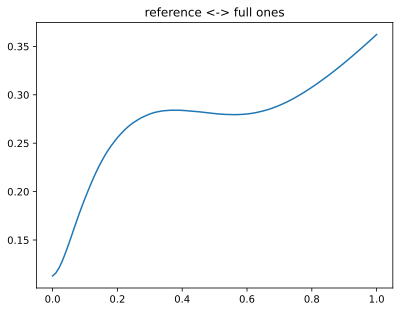

In [11]:
params_1 = mi.TensorXf(params_ref[Scene.COND1])
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> full ones")

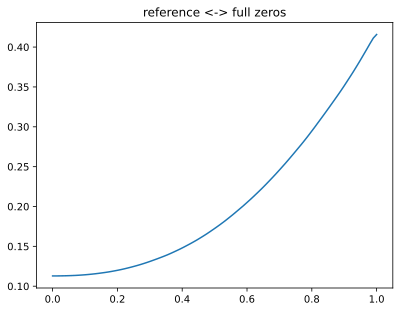

In [12]:
params_1 = mi.TensorXf(params_ref[Scene.COND1])
params_2 = mi.TensorXf(np.zeros((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> full zeros")

## Scene 2

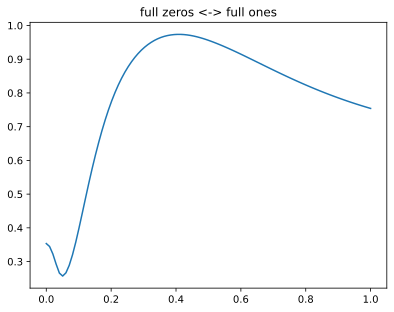

In [13]:
params_1 = mi.TensorXf(np.zeros((512, 512, 1)))
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="full zeros <-> full ones")

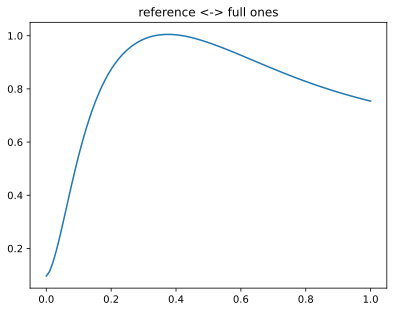

In [14]:
params_1 = mi.TensorXf(params_ref[Scene.COND2])
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> full ones")

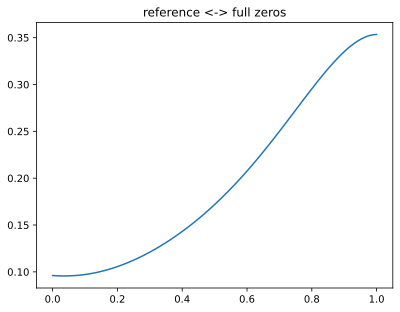

In [15]:
params_1 = mi.TensorXf(params_ref[Scene.COND2])
params_2 = mi.TensorXf(np.zeros((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> full zeros")